In [1]:
dataset_dir =r"C:/Users/User/Desktop/rakin2/insulator-segmentation/"
csv_file = '/home/rakin/Desktop/segment/artifacts/train_data.csv'  # Update with the actual path
import os 

In [2]:
imag_dir = os.path.join(dataset_dir,'images/porcelain')
mask_dir = os.path.join(dataset_dir,'mask/porcelain')
print(imag_dir, mask_dir)
print(len(os.listdir(imag_dir)))
print(len(os.listdir(mask_dir)))
assert len(os.listdir(mask_dir)) == len(os.listdir(imag_dir))



C:/Users/User/Desktop/rakin2/insulator-segmentation/images/porcelain C:/Users/User/Desktop/rakin2/insulator-segmentation/mask/porcelain
15759
15759


In [3]:

images_dir_list = []
mask_dir_list = []
for i in os.listdir(imag_dir): 
    images_dir_list.append(os.path.join(imag_dir,i))
    mask_dir_list.append(os.path.join(mask_dir,i))
    


In [4]:
import pandas as pd 
from PIL.Image import open
from torchmetrics.segmentation import MeanIoU , GeneralizedDiceScore 
from torchmetrics.classification import BinaryAccuracy,BinaryJaccardIndex
from Seg.utils.common import read_yaml
from Seg.utils.logger import logger
from tqdm import tqdm
import matplotlib.pyplot as plt 
import torch
import albumentations as A
import numpy as np
import datetime as dt 
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from  Seg.components.models import  model_list , R2U_Net,AttU_Net
#config = read_yaml(r"Desktop/segment/config/config.yaml")
date_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
logger.info(f"date_time: {date_time}")

# criterion = torch.nn.BCEWithLogitsLoss()
#criterion = torch.nn.CrossEntropyLoss()
criterion = smp.losses.DiceLoss(mode='binary')
# focal loss
#criterion = smp.losses.FocalLoss(mode='binary',gamma=1.0)
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
BinaryJaccardIndex_Score = BinaryJaccardIndex().to('cuda')

C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


[2025-02-16 14:48:30,727: INFO: 3804955329: date_time: 20250216-144830]


In [5]:
Train_config = {
  "device" : "cuda",
  "batch_size" : 6,
  "epochs" : 20,
  "lr" : 0.001,
  "loss" : "dice_loss" #dice_loss
}

Model_config = {
    "model_name" : "linknet",
    "backbone" : "vgg19", #resnet34
    "weights" : "imagenet",
    "in_channels" : 3 
}

Transform_config = {
    #train transform config 
   "image_size" : 512, 
   "shift_limit" : 0.2,
   "scale_limit" : 0.2,
   "rotate_limit" : 30,
   "ShiftScaleRotate_p" : 0.5, 
   "r_shift_limit" : 25,
   "g_shift_limit" : 25,
   "b_shift_limit" : 25,
   "RGB_Shift_p" : 0.5,
   "brightness_limit" : 0.3, 
   "contrast_limit" : 0.3,
   "RandomBrightnessContrast_p" : 0.5
}
Data_injection = {
    "seed" : 42, 
    "dataset_dir" : "Desktop/rakin2/segment/artifacts/dataset.csv",
    "train_csv_dir" : "Desktop/rakin2/segment/artifacts/train_data.csv",
    "test_csv_dir" : "Desktop/rakin2/segment/artifacts/test_data.csv",
    "val_csv_dir" : "Desktop/rakin2/segment/artifacts/val_data.csv"
}


In [6]:
train_config=Train_config
model_config=Model_config
transform_config=Transform_config
data_injecton_config =Data_injection
logger.info(f"train_config: {train_config}") 
logger.info(f"model_config: {model_config}")
logger.info(f"transform_config: {transform_config}")
logger.info(f"data_injecton_config: {data_injecton_config}")



[2025-02-16 14:48:30,896: INFO: 342151172: train_config: {'device': 'cuda', 'batch_size': 6, 'epochs': 20, 'lr': 0.001, 'loss': 'dice_loss'}]
[2025-02-16 14:48:30,898: INFO: 342151172: model_config: {'model_name': 'linknet', 'backbone': 'vgg19', 'weights': 'imagenet', 'in_channels': 3}]
[2025-02-16 14:48:30,899: INFO: 342151172: transform_config: {'image_size': 512, 'shift_limit': 0.2, 'scale_limit': 0.2, 'rotate_limit': 30, 'ShiftScaleRotate_p': 0.5, 'r_shift_limit': 25, 'g_shift_limit': 25, 'b_shift_limit': 25, 'RGB_Shift_p': 0.5, 'brightness_limit': 0.3, 'contrast_limit': 0.3, 'RandomBrightnessContrast_p': 0.5}]
[2025-02-16 14:48:30,900: INFO: 342151172: data_injecton_config: {'seed': 42, 'dataset_dir': 'Desktop/rakin2/segment/artifacts/dataset.csv', 'train_csv_dir': 'Desktop/rakin2/segment/artifacts/train_data.csv', 'test_csv_dir': 'Desktop/rakin2/segment/artifacts/test_data.csv', 'val_csv_dir': 'Desktop/rakin2/segment/artifacts/val_data.csv'}]


(-0.5, 511.5, 511.5, -0.5)

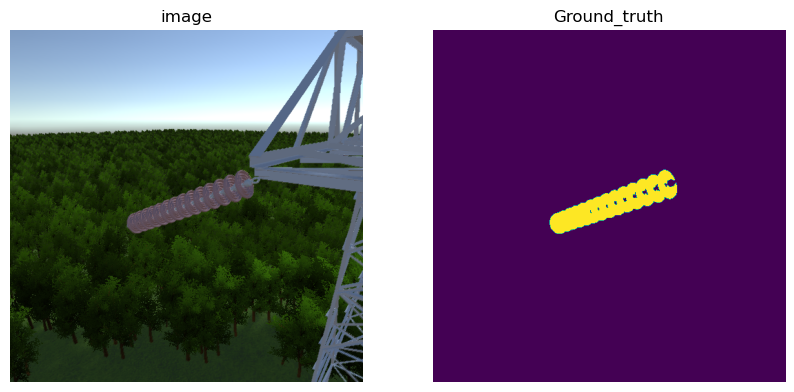

In [7]:


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,8))
ax1.imshow(open(images_dir_list[2]))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(open(mask_dir_list[2]))
ax2.set_title('Ground_truth')
ax2.axis('off')


In [8]:
x=pd.DataFrame({'imag_dir_list': images_dir_list , 'mask_dir_list':mask_dir_list})

In [9]:
x.to_csv('dataset.csv')

In [10]:

from PIL import Image
from torch.utils.data import Dataset



class SegmentDataset(Dataset):
    """
    DroneDataset class for loading the dataset with one-hot encoded masks.

    Args:
        img_path: Path to the images directory.
        mask_path: Path to the masks directory.
        X: List of image names.
        transform: Data augmentation transformations.

    Returns:
        image: Image tensor.
        mask: One-hot encoded mask tensor.
    """

    def __init__(self, csv_path , num_classes=2, transform=None):
        self.dataset = pd.read_csv(csv_path)
        self.img_path = self.dataset['imag_dir_list']
        self.mask_path = self.dataset['mask_dir_list']
        self.num_classes = num_classes  # Number of classes for one-hot encoding
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load image and mask
        image = np.array(Image.open(self.img_path[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_path[idx]).convert("L"))  # Grayscale mask

        # Apply Albumentations transformations (if any)
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # One-hot encode the mask
        mask_one_hot = np.zeros((mask.shape[0], mask.shape[1], self.num_classes), dtype=np.float32)
        
        # Create one-hot encoding using the unique values in the mask
        for i, unique_value in enumerate(np.unique(mask)):
            mask_one_hot[:, :, i][mask == unique_value] = 1
        
        # Normalize the image using Albumentations Normalize
        norm = A.Normalize(mean=(0 ,0, 0), std=(1, 1, 1))(image=image, mask=mask_one_hot)
        
        # Return image and one-hot encoded mask as tensors in [C, H, W] format
        return norm["image"].transpose(2, 0, 1), norm["mask"].transpose(2, 0, 1).astype("float32")



In [11]:

class DataInjection():
    def __init__(self , Dataset_dir) -> None:
        self.dataset = pd.read_csv(Dataset_dir)
        #self.injection_config = config["Data_injection"]
        

    def inject(self):
        logger.info('data injection started')
        if 'Unnamed: 0' in self.dataset.columns:
            dataset_cleaned = self.dataset.drop(columns=['Unnamed: 0'])
        else:
            dataset_cleaned = self.dataset

        logger.info('train data spliting ')
        train_data, temp_data = train_test_split(dataset_cleaned, test_size=0.2, random_state=42)
        logger.info('val test spliting ')
        val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

        logger.info('csv saving started')   
        train_data.to_csv('train_data.csv', index=False)
        logger.info('train csv done ')
        val_data.to_csv('val_data.csv', index=False)
        logger.info('val csv done ')
        test_data.to_csv('test_data.csv', index=False)
        logger.info('test csv done')


In [12]:
dInj = DataInjection("C:/Users/User/Desktop/rakin2/segment/notebook/dataset.csv")
dInj.inject()

[2025-02-16 14:48:31,436: INFO: 3993860970: data injection started]
[2025-02-16 14:48:31,438: INFO: 3993860970: train data spliting ]
[2025-02-16 14:48:31,440: INFO: 3993860970: val test spliting ]
[2025-02-16 14:48:31,443: INFO: 3993860970: csv saving started]
[2025-02-16 14:48:31,484: INFO: 3993860970: train csv done ]
[2025-02-16 14:48:31,490: INFO: 3993860970: val csv done ]
[2025-02-16 14:48:31,499: INFO: 3993860970: test csv done]


In [13]:



def model_selection(model_name: str, model_encoder: str, weight: str):
    """
    arg:
      model_name(str) name of the model
      model_encoder(str) : name of the encoder used


    return : model object with given encoder

    """

    model = smp.create_model(
        arch=model_name,  # name of the architecture, e.g. 'Unet'/ 'FPN' / etc. Case INsensitive!
        encoder_name=model_encoder,
        encoder_weights=weight,
        in_channels=3,
        classes=2,
    )

    return model



transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
    ])
   

In [14]:
model = model_selection(Model_config['model_name'], Model_config['backbone'],Model_config['weights'])
model=model.to('cuda')
#model = AttU_Net(3,2).to('cuda')


In [15]:
Train_DL_config = {
    "train_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/train_data.csv",
    "batch_size": 6,
    "num_workers": 4,
    "shuffle": True
}

Val_DL_config = {
    "val_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/val_data.csv",
    "batch_size": 2,
    "num_workers": 4,
    "shuffle": False,
    "transform": True,
    "random_blur": False
}

Test_DL_config = {
    # setting to val as test dir is corrupted in local drive
   "test_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/test_data.csv",
   "batch_size": 2,
   "num_workers": 4,
   "shuffle": False,
   "transform": True
}

In [17]:

train_data = SegmentDataset(Train_DL_config['train_dirs'],2,transform=transform )
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=Train_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])
test_data = SegmentDataset(Test_DL_config['test_dirs'],2,transform=transform )
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=Test_DL_config['batch_size'], shuffle=Test_DL_config['shuffle'])
val_data = SegmentDataset(Val_DL_config['val_dirs'],2,transform=transform )
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=Val_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=train_config['lr'])

mean_iou_score_for_training = []
dice_score_for_training =[]
accuracy_for_training = []
train_loss=[]
binary_jaccard_index_for_training = []
dice_coefficient_for_training = []

mean_iou_score = []
dice_score =[]
accuracy = []
val_loss =[]
binary_jaccard_index = []
dice_coefficient = []

for epoch in range(train_config['epochs']):    
    model.train()
    total_losses = 0
    pbar = tqdm(enumerate(train_dataloader), total = len(train_dataloader),colour='green')
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat,y)
    
        loss.backward()
        optimizer.step()
        total_losses += loss.item()
        jeq_indx_for_training = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou_for_training = IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values_for_training = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc_for_training = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_iou_score_for_training.append(mean_miou_for_training)
        dice_score_for_training.append(dice_score_values_for_training)
        binary_jaccard_index_for_training.append(jeq_indx_for_training)
        dice_coefficient_for_training.append((2*jeq_indx_for_training*1/(1+jeq_indx_for_training)))
        accuracy_for_training.append(acc_for_training)
        train_loss.append(total_losses/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"train_loss": total_losses / (i + 1) , 
                                  "train_Miou_score": sum(mean_iou_score_for_training)/len(mean_iou_score_for_training) ,
                                    "train_dice_score" : sum(dice_score_for_training)/len(dice_score_for_training),
                                   "train_acc": sum(accuracy_for_training)/len(accuracy_for_training),
                                   "train_binary_jaccard_index": sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training),
                                    "train_dice_coefficient": sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)} )

    # mlflow metrics
    #mlflow.log_metric("train_loss", sum(train_loss) / len(train_loss), step=epoch)
    logger.info(f"Epoch: {epoch} | Training_Loss: {total_losses / len(train_dataloader)}")
    # mlflow metrics
    logger.info(f"train_loss {sum(train_loss) / len(train_loss) }")
    logger.info(f"train_Miou_score {sum(mean_iou_score_for_training)/len(mean_iou_score_for_training)}" )
    logger.info(f"train_dice_score {sum(dice_score_for_training)/len(dice_score_for_training)}" )
    logger.info(f"train_acc {sum(accuracy_for_training)/len(accuracy_for_training)}" )
    logger.info(f"train_binary_jaccard_index: {sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training)}")
    logger.info(f"train_dice_coefficient: {sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)}")

    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()
    
    total_loss = 0.0
    model.eval()
 
    pbar = tqdm(enumerate(val_dataloader), total=len(val_dataloader),colour="blue")
    
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        y_hat = model(x)
        loss = criterion(y_hat, y)
    
        total_loss += loss.item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        binary_jaccard_index.append(jeq_indx)
        dice_score.append(dice_score_values)
        accuracy.append(acc)
        val_loss.append(total_loss/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"eval_loss": total_loss / (i + 1) , 
                                  "eval_Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                                    "eval_dice_score" : sum(dice_score)/len(dice_score),
                                   "eval_acc": sum(accuracy)/len(accuracy),
                                   "eval_binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                                     "eval_dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)} )
        
        #save model  if val loss is minimum
        
        

    #torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin/segment/artifacts/model_ckpt/unet_{date_time}.pth')
    
    logger.info(f"Epoch: {epoch} | Loss: {total_loss / len(val_dataloader)}")
    # mlflow metrics
    logger.info(f"eval_loss {sum(val_loss) / len(val_loss) }")
    logger.info(f"eval_Miou_score {sum(mean_iou_score)/len(mean_iou_score)}" )
    logger.info(f"eval_dice_score {sum(dice_score)/len(dice_score)}" )
    logger.info(f"eval_acc {sum(accuracy)/len(accuracy)}" )
    logger.info(f"eval_binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    logger.info(f"eval_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    
    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()

100%|██████████| 2102/2102 [10:26<00:00,  3.35it/s, epoch=0, train_loss=0.0279, train_Miou_score=0.335, train_dice_score=0.716, train_acc=0.984, train_binary_jaccard_index=0.813, train_dice_coefficient=0.888]

[2025-02-16 14:59:58,019: INFO: 2273413975: Epoch: 0 | Training_Loss: 0.02790946156835692]
[2025-02-16 14:59:58,020: INFO: 2273413975: train_loss 0.06858049524883532]
[2025-02-16 14:59:58,020: INFO: 2273413975: train_Miou_score 0.3352565578691002]
[2025-02-16 14:59:58,021: INFO: 2273413975: train_dice_score 0.7161593994942735]
[2025-02-16 14:59:58,022: INFO: 2273413975: train_acc 0.9840466403938497]
[2025-02-16 14:59:58,022: INFO: 2273413975: train_binary_jaccard_index: 0.8128115883634047]
[2025-02-16 14:59:58,023: INFO: 2273413975: train_dice_coefficient: 0.8883330947451559]



100%|██████████| 788/788 [00:49<00:00, 15.83it/s, epoch=0, eval_loss=0.00954, eval_Miou_score=0.366, eval_dice_score=0.782, eval_acc=0.991, eval_binary_jaccard_index=0.886, eval_dice_coefficient=0.933]

[2025-02-16 15:00:47,809: INFO: 2273413975: Epoch: 0 | Loss: 0.009542826392928961]
[2025-02-16 15:00:47,810: INFO: 2273413975: eval_loss 0.011144297034684843]
[2025-02-16 15:00:47,811: INFO: 2273413975: eval_Miou_score 0.36612170179218506]
[2025-02-16 15:00:47,811: INFO: 2273413975: eval_dice_score 0.7815548265967424]
[2025-02-16 15:00:47,812: INFO: 2273413975: eval_acc 0.9907132671569204]
[2025-02-16 15:00:47,813: INFO: 2273413975: eval_binary_jaccard_index: 0.8856880407553488]
[2025-02-16 15:00:47,813: INFO: 2273413975: eval_dice_coefficient: 0.9330102011809885]



100%|██████████| 2102/2102 [09:50<00:00,  3.56it/s, epoch=1, train_loss=0.0087, train_Miou_score=0.348, train_dice_score=0.754, train_acc=0.988, train_binary_jaccard_index=0.851, train_dice_coefficient=0.913] 

[2025-02-16 15:10:37,966: INFO: 2273413975: Epoch: 1 | Training_Loss: 0.008695353223072926]
[2025-02-16 15:10:37,966: INFO: 2273413975: train_loss 0.038706343275139096]
[2025-02-16 15:10:37,967: INFO: 2273413975: train_Miou_score 0.34750917426121736]
[2025-02-16 15:10:37,967: INFO: 2273413975: train_dice_score 0.7544479956726351]
[2025-02-16 15:10:37,968: INFO: 2273413975: train_acc 0.987749996310637]
[2025-02-16 15:10:37,968: INFO: 2273413975: train_binary_jaccard_index: 0.8514137512921833]
[2025-02-16 15:10:37,969: INFO: 2273413975: train_dice_coefficient: 0.9134673292911762]



100%|██████████| 788/788 [00:47<00:00, 16.73it/s, epoch=1, eval_loss=0.00556, eval_Miou_score=0.37, eval_dice_score=0.81, eval_acc=0.993, eval_binary_jaccard_index=0.909, eval_dice_coefficient=0.947]  

[2025-02-16 15:11:25,073: INFO: 2273413975: Epoch: 1 | Loss: 0.005556042651234544]
[2025-02-16 15:11:25,074: INFO: 2273413975: eval_loss 0.008655255047105851]
[2025-02-16 15:11:25,075: INFO: 2273413975: eval_Miou_score 0.36998312180237797]


[2025-02-16 15:11:25,076: INFO: 2273413975: eval_dice_score 0.8101629503591335]
[2025-02-16 15:11:25,077: INFO: 2273413975: eval_acc 0.9926045642891511]
[2025-02-16 15:11:25,077: INFO: 2273413975: eval_binary_jaccard_index: 0.9090057777827085]
[2025-02-16 15:11:25,078: INFO: 2273413975: eval_dice_coefficient: 0.9473546392880265]


100%|██████████| 2102/2102 [09:49<00:00,  3.57it/s, epoch=2, train_loss=0.00685, train_Miou_score=0.355, train_dice_score=0.775, train_acc=0.99, train_binary_jaccard_index=0.872, train_dice_coefficient=0.926] 

[2025-02-16 15:21:14,488: INFO: 2273413975: Epoch: 2 | Training_Loss: 0.006848729842056216]
[2025-02-16 15:21:14,489: INFO: 2273413975: train_loss 0.02822387990597995]
[2025-02-16 15:21:14,489: INFO: 2273413975: train_Miou_score 0.3545513961616581]
[2025-02-16 15:21:14,490: INFO: 2273413975: train_dice_score 0.7750428473417991]
[2025-02-16 15:21:14,491: INFO: 2273413975: train_acc 0.9895645769444715]
[2025-02-16 15:21:14,491: INFO: 2273413975: train_binary_jaccard_index: 0.871542090669988]
[2025-02-16 15:21:14,492: INFO: 2273413975: train_dice_coefficient: 0.9260818542379095]



100%|██████████| 788/788 [00:46<00:00, 16.82it/s, epoch=2, eval_loss=0.0112, eval_Miou_score=0.359, eval_dice_score=0.804, eval_acc=0.991, eval_binary_jaccard_index=0.894, eval_dice_coefficient=0.936]

[2025-02-16 15:22:01,352: INFO: 2273413975: Epoch: 2 | Loss: 0.011217231677873486]
[2025-02-16 15:22:01,353: INFO: 2273413975: eval_loss 0.00971631744062465]
[2025-02-16 15:22:01,354: INFO: 2273413975: eval_Miou_score 0.35936155148534427]
[2025-02-16 15:22:01,354: INFO: 2273413975: eval_dice_score 0.8041049041541044]
[2025-02-16 15:22:01,355: INFO: 2273413975: eval_acc 0.9913377447176706]
[2025-02-16 15:22:01,356: INFO: 2273413975: eval_binary_jaccard_index: 0.8941046829727776]
[2025-02-16 15:22:01,356: INFO: 2273413975: eval_dice_coefficient: 0.9364301698021399]



100%|██████████| 2102/2102 [09:49<00:00,  3.57it/s, epoch=3, train_loss=0.00801, train_Miou_score=0.357, train_dice_score=0.782, train_acc=0.99, train_binary_jaccard_index=0.878, train_dice_coefficient=0.93] 

[2025-02-16 15:31:50,691: INFO: 2273413975: Epoch: 3 | Training_Loss: 0.008013427853017166]
[2025-02-16 15:31:50,692: INFO: 2273413975: train_loss 0.022778651288676684]
[2025-02-16 15:31:50,692: INFO: 2273413975: train_Miou_score 0.35659935798843373]
[2025-02-16 15:31:50,693: INFO: 2273413975: train_dice_score 0.7824733949463095]
[2025-02-16 15:31:50,695: INFO: 2273413975: train_acc 0.9901794317035761]
[2025-02-16 15:31:50,695: INFO: 2273413975: train_binary_jaccard_index: 0.8781538769163255]
[2025-02-16 15:31:50,696: INFO: 2273413975: train_dice_coefficient: 0.9300537094089966]



100%|██████████| 788/788 [00:47<00:00, 16.76it/s, epoch=3, eval_loss=0.00584, eval_Miou_score=0.363, eval_dice_score=0.813, eval_acc=0.992, eval_binary_jaccard_index=0.903, eval_dice_coefficient=0.942]

[2025-02-16 15:32:37,714: INFO: 2273413975: Epoch: 3 | Loss: 0.005838139635052172]
[2025-02-16 15:32:37,714: INFO: 2273413975: eval_loss 0.008743650400125914]
[2025-02-16 15:32:37,715: INFO: 2273413975: eval_Miou_score 0.36294229595796657]
[2025-02-16 15:32:37,716: INFO: 2273413975: eval_dice_score 0.812874855409816]
[2025-02-16 15:32:37,716: INFO: 2273413975: eval_acc 0.9920487615662783]
[2025-02-16 15:32:37,717: INFO: 2273413975: eval_binary_jaccard_index: 0.9027548130958573]
[2025-02-16 15:32:37,718: INFO: 2273413975: eval_dice_coefficient: 0.9421601094687961]



100%|██████████| 2102/2102 [09:46<00:00,  3.58it/s, epoch=4, train_loss=0.00546, train_Miou_score=0.36, train_dice_score=0.793, train_acc=0.991, train_binary_jaccard_index=0.888, train_dice_coefficient=0.936] 

[2025-02-16 15:42:24,506: INFO: 2273413975: Epoch: 4 | Training_Loss: 0.005459125585265664]
[2025-02-16 15:42:24,507: INFO: 2273413975: train_loss 0.019310252097268815]
[2025-02-16 15:42:24,507: INFO: 2273413975: train_Miou_score 0.35998811524230223]
[2025-02-16 15:42:24,508: INFO: 2273413975: train_dice_score 0.7933694358496837]
[2025-02-16 15:42:24,509: INFO: 2273413975: train_acc 0.9910553173662706]
[2025-02-16 15:42:24,509: INFO: 2273413975: train_binary_jaccard_index: 0.8883876013285086]
[2025-02-16 15:42:24,510: INFO: 2273413975: train_dice_coefficient: 0.9363431817207333]



100%|██████████| 788/788 [00:47<00:00, 16.69it/s, epoch=4, eval_loss=0.0072, eval_Miou_score=0.364, eval_dice_score=0.817, eval_acc=0.992, eval_binary_jaccard_index=0.905, eval_dice_coefficient=0.944] 

[2025-02-16 15:43:11,717: INFO: 2273413975: Epoch: 4 | Loss: 0.007195220002668158]
[2025-02-16 15:43:11,718: INFO: 2273413975: eval_loss 0.008201898791987891]
[2025-02-16 15:43:11,719: INFO: 2273413975: eval_Miou_score 0.3644906187746768]
[2025-02-16 15:43:11,719: INFO: 2273413975: eval_dice_score 0.8166405808728964]
[2025-02-16 15:43:11,720: INFO: 2273413975: eval_acc 0.9922030550574288]
[2025-02-16 15:43:11,721: INFO: 2273413975: eval_binary_jaccard_index: 0.9050798713962364]
[2025-02-16 15:43:11,722: INFO: 2273413975: eval_dice_coefficient: 0.9438138859941317]



100%|██████████| 2102/2102 [09:48<00:00,  3.57it/s, epoch=5, train_loss=0.00522, train_Miou_score=0.363, train_dice_score=0.802, train_acc=0.992, train_binary_jaccard_index=0.896, train_dice_coefficient=0.941]

[2025-02-16 15:53:00,435: INFO: 2273413975: Epoch: 5 | Training_Loss: 0.005216379714624639]
[2025-02-16 15:53:00,436: INFO: 2273413975: train_loss 0.01699924020704499]
[2025-02-16 15:53:00,437: INFO: 2273413975: train_Miou_score 0.36260459787288224]
[2025-02-16 15:53:00,438: INFO: 2273413975: train_dice_score 0.8017164220456878]
[2025-02-16 15:53:00,439: INFO: 2273413975: train_acc 0.9916785901363335]
[2025-02-16 15:53:00,439: INFO: 2273413975: train_binary_jaccard_index: 0.8958286919725289]
[2025-02-16 15:53:00,440: INFO: 2273413975: train_dice_coefficient: 0.9408649885564798]



100%|██████████| 788/788 [00:47<00:00, 16.56it/s, epoch=5, eval_loss=0.00461, eval_Miou_score=0.366, eval_dice_score=0.824, eval_acc=0.993, eval_binary_jaccard_index=0.911, eval_dice_coefficient=0.948]

[2025-02-16 15:53:48,023: INFO: 2273413975: Epoch: 5 | Loss: 0.004608741644675357]
[2025-02-16 15:53:48,023: INFO: 2273413975: eval_loss 0.007575445458321888]
[2025-02-16 15:53:48,024: INFO: 2273413975: eval_Miou_score 0.36647859575382913]
[2025-02-16 15:53:48,025: INFO: 2273413975: eval_dice_score 0.8239308335139163]
[2025-02-16 15:53:48,026: INFO: 2273413975: eval_acc 0.9927362221751721]
[2025-02-16 15:53:48,026: INFO: 2273413975: eval_binary_jaccard_index: 0.9113072230048831]
[2025-02-16 15:53:48,027: INFO: 2273413975: eval_dice_coefficient: 0.9479123567226402]



100%|██████████| 2102/2102 [09:52<00:00,  3.55it/s, epoch=6, train_loss=0.00514, train_Miou_score=0.364, train_dice_score=0.807, train_acc=0.992, train_binary_jaccard_index=0.901, train_dice_coefficient=0.944]

[2025-02-16 16:03:40,212: INFO: 2273413975: Epoch: 6 | Training_Loss: 0.005140320473234501]
[2025-02-16 16:03:40,213: INFO: 2273413975: train_loss 0.015395208607930259]
[2025-02-16 16:03:40,214: INFO: 2273413975: train_Miou_score 0.36437672150542966]
[2025-02-16 16:03:40,214: INFO: 2273413975: train_dice_score 0.8073839578586147]
[2025-02-16 16:03:40,215: INFO: 2273413975: train_acc 0.9921345241986589]
[2025-02-16 16:03:40,216: INFO: 2273413975: train_binary_jaccard_index: 0.9011287255147091]
[2025-02-16 16:03:40,216: INFO: 2273413975: train_dice_coefficient: 0.944102858952953]



100%|██████████| 788/788 [00:48<00:00, 16.36it/s, epoch=6, eval_loss=0.00563, eval_Miou_score=0.368, eval_dice_score=0.828, eval_acc=0.993, eval_binary_jaccard_index=0.915, eval_dice_coefficient=0.95] 

[2025-02-16 16:04:28,383: INFO: 2273413975: Epoch: 6 | Loss: 0.0056257467281999925]
[2025-02-16 16:04:28,383: INFO: 2273413975: eval_loss 0.007340393640417979]
[2025-02-16 16:04:28,384: INFO: 2273413975: eval_Miou_score 0.36794333418772474]
[2025-02-16 16:04:28,384: INFO: 2273413975: eval_dice_score 0.828139740079871]
[2025-02-16 16:04:28,385: INFO: 2273413975: eval_acc 0.9929718162116147]
[2025-02-16 16:04:28,386: INFO: 2273413975: eval_binary_jaccard_index: 0.9146519474931023]
[2025-02-16 16:04:28,387: INFO: 2273413975: eval_dice_coefficient: 0.9499170920402383]



100%|██████████| 2102/2102 [09:50<00:00,  3.56it/s, epoch=7, train_loss=0.00449, train_Miou_score=0.366, train_dice_score=0.813, train_acc=0.993, train_binary_jaccard_index=0.906, train_dice_coefficient=0.947]

[2025-02-16 16:14:18,567: INFO: 2273413975: Epoch: 7 | Training_Loss: 0.00449475963607955]
[2025-02-16 16:14:18,568: INFO: 2273413975: train_loss 0.014027299285650052]
[2025-02-16 16:14:18,569: INFO: 2273413975: train_Miou_score 0.36606791130285693]
[2025-02-16 16:14:18,570: INFO: 2273413975: train_dice_score 0.8128944657861276]
[2025-02-16 16:14:18,571: INFO: 2273413975: train_acc 0.9925568967979653]
[2025-02-16 16:14:18,571: INFO: 2273413975: train_binary_jaccard_index: 0.9062567528622574]
[2025-02-16 16:14:18,572: INFO: 2273413975: train_dice_coefficient: 0.9471981305554168]



100%|██████████| 788/788 [00:48<00:00, 16.25it/s, epoch=7, eval_loss=0.004, eval_Miou_score=0.369, eval_dice_score=0.832, eval_acc=0.993, eval_binary_jaccard_index=0.919, eval_dice_coefficient=0.953]  

[2025-02-16 16:15:07,082: INFO: 2273413975: Epoch: 7 | Loss: 0.0040040617515593015]
[2025-02-16 16:15:07,083: INFO: 2273413975: eval_loss 0.006853254229293571]
[2025-02-16 16:15:07,084: INFO: 2273413975: eval_Miou_score 0.3694171736099306]
[2025-02-16 16:15:07,084: INFO: 2273413975: eval_dice_score 0.8323511521590207]
[2025-02-16 16:15:07,085: INFO: 2273413975: eval_acc 0.9933510347066192]
[2025-02-16 16:15:07,085: INFO: 2273413975: eval_binary_jaccard_index: 0.9189774028774881]
[2025-02-16 16:15:07,086: INFO: 2273413975: eval_dice_coefficient: 0.9526265277432102]



100%|██████████| 2102/2102 [09:51<00:00,  3.56it/s, epoch=8, train_loss=0.0044, train_Miou_score=0.368, train_dice_score=0.818, train_acc=0.993, train_binary_jaccard_index=0.91, train_dice_coefficient=0.95]   

[2025-02-16 16:24:58,339: INFO: 2273413975: Epoch: 8 | Training_Loss: 0.004398177143055184]
[2025-02-16 16:24:58,340: INFO: 2273413975: train_loss 0.013033061596002295]
[2025-02-16 16:24:58,342: INFO: 2273413975: train_Miou_score 0.3678064574521476]
[2025-02-16 16:24:58,343: INFO: 2273413975: train_dice_score 0.8175747505558405]
[2025-02-16 16:24:58,345: INFO: 2273413975: train_acc 0.9928960962872233]
[2025-02-16 16:24:58,346: INFO: 2273413975: train_binary_jaccard_index: 0.9104935433500941]
[2025-02-16 16:24:58,347: INFO: 2273413975: train_dice_coefficient: 0.9497217548298457]



100%|██████████| 788/788 [00:47<00:00, 16.51it/s, epoch=8, eval_loss=0.00571, eval_Miou_score=0.369, eval_dice_score=0.835, eval_acc=0.993, eval_binary_jaccard_index=0.921, eval_dice_coefficient=0.954]

[2025-02-16 16:25:46,070: INFO: 2273413975: Epoch: 8 | Loss: 0.005712636987569974]
[2025-02-16 16:25:46,071: INFO: 2273413975: eval_loss 0.00676529218402909]
[2025-02-16 16:25:46,072: INFO: 2273413975: eval_Miou_score 0.36944860620363745]
[2025-02-16 16:25:46,072: INFO: 2273413975: eval_dice_score 0.8353182232998589]
[2025-02-16 16:25:46,073: INFO: 2273413975: eval_acc 0.9934558521470847]
[2025-02-16 16:25:46,074: INFO: 2273413975: eval_binary_jaccard_index: 0.9208984748017541]
[2025-02-16 16:25:46,075: INFO: 2273413975: eval_dice_coefficient: 0.9537890061895188]



100%|██████████| 2102/2102 [09:51<00:00,  3.56it/s, epoch=9, train_loss=0.00418, train_Miou_score=0.369, train_dice_score=0.822, train_acc=0.993, train_binary_jaccard_index=0.914, train_dice_coefficient=0.952]

[2025-02-16 16:35:37,223: INFO: 2273413975: Epoch: 9 | Training_Loss: 0.00418043451350037]
[2025-02-16 16:35:37,224: INFO: 2273413975: train_loss 0.012196018755645233]
[2025-02-16 16:35:37,225: INFO: 2273413975: train_Miou_score 0.369231320591865]
[2025-02-16 16:35:37,226: INFO: 2273413975: train_dice_score 0.821519857427933]
[2025-02-16 16:35:37,228: INFO: 2273413975: train_acc 0.9931891067866254]
[2025-02-16 16:35:37,231: INFO: 2273413975: train_binary_jaccard_index: 0.9141453238503634]
[2025-02-16 16:35:37,232: INFO: 2273413975: train_dice_coefficient: 0.9519003288882074]



100%|██████████| 788/788 [00:47<00:00, 16.46it/s, epoch=9, eval_loss=0.00393, eval_Miou_score=0.371, eval_dice_score=0.838, eval_acc=0.994, eval_binary_jaccard_index=0.924, eval_dice_coefficient=0.955]

[2025-02-16 16:36:25,119: INFO: 2273413975: Epoch: 9 | Loss: 0.003932346849877217]
[2025-02-16 16:36:25,120: INFO: 2273413975: eval_loss 0.006508671507054285]
[2025-02-16 16:36:25,121: INFO: 2273413975: eval_Miou_score 0.37069614509222226]
[2025-02-16 16:36:25,121: INFO: 2273413975: eval_dice_score 0.8384136532714619]
[2025-02-16 16:36:25,122: INFO: 2273413975: eval_acc 0.9937176917410139]
[2025-02-16 16:36:25,122: INFO: 2273413975: eval_binary_jaccard_index: 0.9236157975793073]
[2025-02-16 16:36:25,123: INFO: 2273413975: eval_dice_coefficient: 0.9554876666575973]



100%|██████████| 2102/2102 [09:51<00:00,  3.55it/s, epoch=10, train_loss=0.00426, train_Miou_score=0.37, train_dice_score=0.825, train_acc=0.993, train_binary_jaccard_index=0.917, train_dice_coefficient=0.954]

[2025-02-16 16:46:16,907: INFO: 2273413975: Epoch: 10 | Training_Loss: 0.004263889721526519]
[2025-02-16 16:46:16,908: INFO: 2273413975: train_loss 0.011481224599752754]
[2025-02-16 16:46:16,909: INFO: 2273413975: train_Miou_score 0.37024198159969873]
[2025-02-16 16:46:16,910: INFO: 2273413975: train_dice_score 0.824649138141534]
[2025-02-16 16:46:16,910: INFO: 2273413975: train_acc 0.9934214527487765]
[2025-02-16 16:46:16,911: INFO: 2273413975: train_binary_jaccard_index: 0.9170205696563997]
[2025-02-16 16:46:16,912: INFO: 2273413975: train_dice_coefficient: 0.9536065952130991]



100%|██████████| 788/788 [00:47<00:00, 16.61it/s, epoch=10, eval_loss=0.00547, eval_Miou_score=0.371, eval_dice_score=0.839, eval_acc=0.994, eval_binary_jaccard_index=0.925, eval_dice_coefficient=0.956]

[2025-02-16 16:47:04,369: INFO: 2273413975: Epoch: 10 | Loss: 0.005466209828551045]
[2025-02-16 16:47:04,370: INFO: 2273413975: eval_loss 0.006408464983051569]
[2025-02-16 16:47:04,370: INFO: 2273413975: eval_Miou_score 0.37085853677565755]
[2025-02-16 16:47:04,371: INFO: 2273413975: eval_dice_score 0.8388688976388213]
[2025-02-16 16:47:04,372: INFO: 2273413975: eval_acc 0.9937925937267069]


[2025-02-16 16:47:04,373: INFO: 2273413975: eval_binary_jaccard_index: 0.9245627052023883]
[2025-02-16 16:47:04,374: INFO: 2273413975: eval_dice_coefficient: 0.9561579742451822]


100%|██████████| 2102/2102 [09:51<00:00,  3.55it/s, epoch=11, train_loss=0.00399, train_Miou_score=0.371, train_dice_score=0.828, train_acc=0.994, train_binary_jaccard_index=0.92, train_dice_coefficient=0.955] 

[2025-02-16 16:56:55,941: INFO: 2273413975: Epoch: 11 | Training_Loss: 0.0039935294896732846]
[2025-02-16 16:56:55,942: INFO: 2273413975: train_loss 0.010878461331195917]
[2025-02-16 16:56:55,943: INFO: 2273413975: train_Miou_score 0.3713261761912019]
[2025-02-16 16:56:55,944: INFO: 2273413975: train_dice_score 0.8279447948438718]
[2025-02-16 16:56:55,945: INFO: 2273413975: train_acc 0.9936375602715892]
[2025-02-16 16:56:55,946: INFO: 2273413975: train_binary_jaccard_index: 0.9197087954798323]
[2025-02-16 16:56:55,946: INFO: 2273413975: train_dice_coefficient: 0.9551971227724627]



100%|██████████| 788/788 [00:48<00:00, 16.32it/s, epoch=11, eval_loss=0.00321, eval_Miou_score=0.372, eval_dice_score=0.842, eval_acc=0.994, eval_binary_jaccard_index=0.927, eval_dice_coefficient=0.958]

[2025-02-16 16:57:44,248: INFO: 2273413975: Epoch: 11 | Loss: 0.0032054194187754906]
[2025-02-16 16:57:44,248: INFO: 2273413975: eval_loss 0.006176858637526901]
[2025-02-16 16:57:44,249: INFO: 2273413975: eval_Miou_score 0.3718367734392703]
[2025-02-16 16:57:44,250: INFO: 2273413975: eval_dice_score 0.8415931258321063]
[2025-02-16 16:57:44,251: INFO: 2273413975: eval_acc 0.9940432187062633]
[2025-02-16 16:57:44,251: INFO: 2273413975: eval_binary_jaccard_index: 0.9274768559218821]
[2025-02-16 16:57:44,251: INFO: 2273413975: eval_dice_coefficient: 0.9579774105400045]



100%|██████████| 2102/2102 [10:09<00:00,  3.45it/s, epoch=12, train_loss=0.00389, train_Miou_score=0.372, train_dice_score=0.831, train_acc=0.994, train_binary_jaccard_index=0.922, train_dice_coefficient=0.957]

[2025-02-16 17:07:53,393: INFO: 2273413975: Epoch: 12 | Training_Loss: 0.003888338237121829]
[2025-02-16 17:07:53,393: INFO: 2273413975: train_loss 0.010359612842617638]
[2025-02-16 17:07:53,394: INFO: 2273413975: train_Miou_score 0.37216156417895074]
[2025-02-16 17:07:53,395: INFO: 2273413975: train_dice_score 0.8306129905428951]
[2025-02-16 17:07:53,396: INFO: 2273413975: train_acc 0.993828495440228]
[2025-02-16 17:07:53,397: INFO: 2273413975: train_binary_jaccard_index: 0.922063480063914]
[2025-02-16 17:07:53,398: INFO: 2273413975: train_dice_coefficient: 0.9565834216364207]



100%|██████████| 788/788 [00:48<00:00, 16.14it/s, epoch=12, eval_loss=0.00359, eval_Miou_score=0.372, eval_dice_score=0.844, eval_acc=0.994, eval_binary_jaccard_index=0.93, eval_dice_coefficient=0.959] 

[2025-02-16 17:08:42,221: INFO: 2273413975: Epoch: 12 | Loss: 0.003591328632407987]
[2025-02-16 17:08:42,221: INFO: 2273413975: eval_loss 0.0060097618593979]
[2025-02-16 17:08:42,222: INFO: 2273413975: eval_Miou_score 0.3721885938790679]
[2025-02-16 17:08:42,222: INFO: 2273413975: eval_dice_score 0.8439968166025904]
[2025-02-16 17:08:42,223: INFO: 2273413975: eval_acc 0.9942254897255024]
[2025-02-16 17:08:42,224: INFO: 2273413975: eval_binary_jaccard_index: 0.9297166944822178]
[2025-02-16 17:08:42,224: INFO: 2273413975: eval_dice_coefficient: 0.9593946641275479]



100%|██████████| 2102/2102 [09:59<00:00,  3.51it/s, epoch=13, train_loss=0.00369, train_Miou_score=0.373, train_dice_score=0.833, train_acc=0.994, train_binary_jaccard_index=0.924, train_dice_coefficient=0.958]

[2025-02-16 17:18:41,929: INFO: 2273413975: Epoch: 13 | Training_Loss: 0.003693360385159784]
[2025-02-16 17:18:41,930: INFO: 2273413975: train_loss 0.009862557402084356]
[2025-02-16 17:18:41,931: INFO: 2273413975: train_Miou_score 0.3729574249064115]
[2025-02-16 17:18:41,932: INFO: 2273413975: train_dice_score 0.8330641638213383]
[2025-02-16 17:18:41,933: INFO: 2273413975: train_acc 0.9940059564129659]
[2025-02-16 17:18:41,934: INFO: 2273413975: train_binary_jaccard_index: 0.9242624959263956]
[2025-02-16 17:18:41,935: INFO: 2273413975: train_dice_coefficient: 0.9578845607970012]



100%|██████████| 788/788 [00:48<00:00, 16.36it/s, epoch=13, eval_loss=0.00397, eval_Miou_score=0.373, eval_dice_score=0.847, eval_acc=0.994, eval_binary_jaccard_index=0.932, eval_dice_coefficient=0.961]

[2025-02-16 17:19:30,116: INFO: 2273413975: Epoch: 13 | Loss: 0.003973664139127973]
[2025-02-16 17:19:30,117: INFO: 2273413975: eval_loss 0.0058488147021790666]
[2025-02-16 17:19:30,118: INFO: 2273413975: eval_Miou_score 0.373181877812682]
[2025-02-16 17:19:30,118: INFO: 2273413975: eval_dice_score 0.8465198763608027]
[2025-02-16 17:19:30,119: INFO: 2273413975: eval_acc 0.9943546437975114]
[2025-02-16 17:19:30,119: INFO: 2273413975: eval_binary_jaccard_index: 0.9316781752201188]
[2025-02-16 17:19:30,120: INFO: 2273413975: eval_dice_coefficient: 0.9606024632923782]



100%|██████████| 2102/2102 [09:54<00:00,  3.54it/s, epoch=14, train_loss=0.00384, train_Miou_score=0.374, train_dice_score=0.835, train_acc=0.994, train_binary_jaccard_index=0.926, train_dice_coefficient=0.959]

[2025-02-16 17:29:24,515: INFO: 2273413975: Epoch: 14 | Training_Loss: 0.0038444390476146954]
[2025-02-16 17:29:24,517: INFO: 2273413975: train_loss 0.009449718610494219]
[2025-02-16 17:29:24,518: INFO: 2273413975: train_Miou_score 0.3735899669646064]
[2025-02-16 17:29:24,519: INFO: 2273413975: train_dice_score 0.8351499111914716]
[2025-02-16 17:29:24,520: INFO: 2273413975: train_acc 0.9941497844172175]
[2025-02-16 17:29:24,522: INFO: 2273413975: train_binary_jaccard_index: 0.9260945523646269]
[2025-02-16 17:29:24,523: INFO: 2273413975: train_dice_coefficient: 0.9589657941785918]



100%|██████████| 788/788 [00:48<00:00, 16.35it/s, epoch=14, eval_loss=0.0034, eval_Miou_score=0.374, eval_dice_score=0.848, eval_acc=0.995, eval_binary_jaccard_index=0.933, eval_dice_coefficient=0.962] 

[2025-02-16 17:30:12,739: INFO: 2273413975: Epoch: 14 | Loss: 0.0034045474178294845]
[2025-02-16 17:30:12,740: INFO: 2273413975: eval_loss 0.0056420086492113275]
[2025-02-16 17:30:12,740: INFO: 2273413975: eval_Miou_score 0.37398187257120996]
[2025-02-16 17:30:12,741: INFO: 2273413975: eval_dice_score 0.8481395942181059]
[2025-02-16 17:30:12,743: INFO: 2273413975: eval_acc 0.9945046942851266]
[2025-02-16 17:30:12,744: INFO: 2273413975: eval_binary_jaccard_index: 0.9334375096245491]
[2025-02-16 17:30:12,744: INFO: 2273413975: eval_dice_coefficient: 0.9617306195546331]



100%|██████████| 2102/2102 [08:23<00:00,  4.18it/s, epoch=15, train_loss=0.00341, train_Miou_score=0.374, train_dice_score=0.837, train_acc=0.994, train_binary_jaccard_index=0.928, train_dice_coefficient=0.96]

[2025-02-16 17:38:35,780: INFO: 2273413975: Epoch: 15 | Training_Loss: 0.003413805470480225]
[2025-02-16 17:38:35,780: INFO: 2273413975: train_loss 0.00906767228597185]
[2025-02-16 17:38:35,781: INFO: 2273413975: train_Miou_score 0.37419466131152346]
[2025-02-16 17:38:35,782: INFO: 2273413975: train_dice_score 0.8371841684585264]
[2025-02-16 17:38:35,782: INFO: 2273413975: train_acc 0.9943024760181285]
[2025-02-16 17:38:35,782: INFO: 2273413975: train_binary_jaccard_index: 0.9279548116254271]
[2025-02-16 17:38:35,783: INFO: 2273413975: train_dice_coefficient: 0.9600545956187839]



100%|██████████| 788/788 [00:33<00:00, 23.75it/s, epoch=15, eval_loss=0.00469, eval_Miou_score=0.374, eval_dice_score=0.849, eval_acc=0.995, eval_binary_jaccard_index=0.934, eval_dice_coefficient=0.962]

[2025-02-16 17:39:08,968: INFO: 2273413975: Epoch: 15 | Loss: 0.004692477245016147]
[2025-02-16 17:39:08,968: INFO: 2273413975: eval_loss 0.0055789607830198295]
[2025-02-16 17:39:08,968: INFO: 2273413975: eval_Miou_score 0.3741847849739828]
[2025-02-16 17:39:08,969: INFO: 2273413975: eval_dice_score 0.8493584243234703]
[2025-02-16 17:39:08,969: INFO: 2273413975: eval_acc 0.994555487699315]
[2025-02-16 17:39:08,970: INFO: 2273413975: eval_binary_jaccard_index: 0.9340906595201988]
[2025-02-16 17:39:08,970: INFO: 2273413975: eval_dice_coefficient: 0.96216730012453]



100%|██████████| 2102/2102 [08:20<00:00,  4.20it/s, epoch=16, train_loss=0.00332, train_Miou_score=0.375, train_dice_score=0.839, train_acc=0.994, train_binary_jaccard_index=0.93, train_dice_coefficient=0.961] 

[2025-02-16 17:47:29,872: INFO: 2273413975: Epoch: 16 | Training_Loss: 0.003323949710399508]
[2025-02-16 17:47:29,872: INFO: 2273413975: train_loss 0.008770565288909881]
[2025-02-16 17:47:29,873: INFO: 2273413975: train_Miou_score 0.37476523886971363]
[2025-02-16 17:47:29,874: INFO: 2273413975: train_dice_score 0.8391111278670337]
[2025-02-16 17:47:29,874: INFO: 2273413975: train_acc 0.9944426361455777]
[2025-02-16 17:47:29,874: INFO: 2273413975: train_binary_jaccard_index: 0.9296330732860603]
[2025-02-16 17:47:29,875: INFO: 2273413975: train_dice_coefficient: 0.9610436335728539]



100%|██████████| 788/788 [00:33<00:00, 23.31it/s, epoch=16, eval_loss=0.00327, eval_Miou_score=0.375, eval_dice_score=0.852, eval_acc=0.995, eval_binary_jaccard_index=0.936, eval_dice_coefficient=0.963]

[2025-02-16 17:48:03,684: INFO: 2273413975: Epoch: 16 | Loss: 0.0032720053710308173]
[2025-02-16 17:48:03,684: INFO: 2273413975: eval_loss 0.00549431045102154]
[2025-02-16 17:48:03,685: INFO: 2273413975: eval_Miou_score 0.37509122676361784]
[2025-02-16 17:48:03,685: INFO: 2273413975: eval_dice_score 0.8515919647760751]
[2025-02-16 17:48:03,685: INFO: 2273413975: eval_acc 0.9946835669662462]
[2025-02-16 17:48:03,686: INFO: 2273413975: eval_binary_jaccard_index: 0.9358356733241631]
[2025-02-16 17:48:03,686: INFO: 2273413975: eval_dice_coefficient: 0.9632410434456058]



100%|██████████| 2102/2102 [08:21<00:00,  4.19it/s, epoch=17, train_loss=0.00336, train_Miou_score=0.375, train_dice_score=0.841, train_acc=0.995, train_binary_jaccard_index=0.931, train_dice_coefficient=0.962]

[2025-02-16 17:56:24,805: INFO: 2273413975: Epoch: 17 | Training_Loss: 0.0033584000891895096]
[2025-02-16 17:56:24,805: INFO: 2273413975: train_loss 0.00846443803078991]
[2025-02-16 17:56:24,806: INFO: 2273413975: train_Miou_score 0.3753457287390847]
[2025-02-16 17:56:24,806: INFO: 2273413975: train_dice_score 0.8409025445366827]
[2025-02-16 17:56:24,807: INFO: 2273413975: train_acc 0.9945650502136689]
[2025-02-16 17:56:24,807: INFO: 2273413975: train_binary_jaccard_index: 0.9311333695303116]
[2025-02-16 17:56:24,808: INFO: 2273413975: train_dice_coefficient: 0.9619219327674196]



100%|██████████| 788/788 [00:33<00:00, 23.56it/s, epoch=17, eval_loss=0.00352, eval_Miou_score=0.375, eval_dice_score=0.852, eval_acc=0.995, eval_binary_jaccard_index=0.937, eval_dice_coefficient=0.964]

[2025-02-16 17:56:58,259: INFO: 2273413975: Epoch: 17 | Loss: 0.0035175848279507633]
[2025-02-16 17:56:58,259: INFO: 2273413975: eval_loss 0.005385893889460806]
[2025-02-16 17:56:58,260: INFO: 2273413975: eval_Miou_score 0.3754089528350559]
[2025-02-16 17:56:58,260: INFO: 2273413975: eval_dice_score 0.8524639882014416]
[2025-02-16 17:56:58,261: INFO: 2273413975: eval_acc 0.9947840141429782]
[2025-02-16 17:56:58,261: INFO: 2273413975: eval_binary_jaccard_index: 0.9368062438997474]
[2025-02-16 17:56:58,262: INFO: 2273413975: eval_dice_coefficient: 0.9638791457152392]



100%|██████████| 2102/2102 [08:21<00:00,  4.19it/s, epoch=18, train_loss=0.00346, train_Miou_score=0.376, train_dice_score=0.842, train_acc=0.995, train_binary_jaccard_index=0.932, train_dice_coefficient=0.963]

[2025-02-16 18:05:19,492: INFO: 2273413975: Epoch: 18 | Training_Loss: 0.0034574445205909883]
[2025-02-16 18:05:19,492: INFO: 2273413975: train_loss 0.0081944303591533]
[2025-02-16 18:05:19,493: INFO: 2273413975: train_Miou_score 0.37587821284354084]
[2025-02-16 18:05:19,494: INFO: 2273413975: train_dice_score 0.8423580195089889]
[2025-02-16 18:05:19,494: INFO: 2273413975: train_acc 0.9946696673186864]
[2025-02-16 18:05:19,494: INFO: 2273413975: train_binary_jaccard_index: 0.9324564671292106]
[2025-02-16 18:05:19,495: INFO: 2273413975: train_dice_coefficient: 0.9626969782512373]



100%|██████████| 788/788 [00:34<00:00, 23.13it/s, epoch=18, eval_loss=0.00454, eval_Miou_score=0.376, eval_dice_score=0.853, eval_acc=0.995, eval_binary_jaccard_index=0.937, eval_dice_coefficient=0.964]

[2025-02-16 18:05:53,566: INFO: 2273413975: Epoch: 18 | Loss: 0.004541201337339915]
[2025-02-16 18:05:53,566: INFO: 2273413975: eval_loss 0.005367181158622672]
[2025-02-16 18:05:53,567: INFO: 2273413975: eval_Miou_score 0.37567045730130605]
[2025-02-16 18:05:53,567: INFO: 2273413975: eval_dice_score 0.8529248453719995]
[2025-02-16 18:05:53,567: INFO: 2273413975: eval_acc 0.9948206351716156]
[2025-02-16 18:05:53,568: INFO: 2273413975: eval_binary_jaccard_index: 0.93726916935478]
[2025-02-16 18:05:53,568: INFO: 2273413975: eval_dice_coefficient: 0.9641780205088588]



100%|██████████| 2102/2102 [08:21<00:00,  4.19it/s, epoch=19, train_loss=0.00342, train_Miou_score=0.376, train_dice_score=0.844, train_acc=0.995, train_binary_jaccard_index=0.934, train_dice_coefficient=0.963]

[2025-02-16 18:14:14,987: INFO: 2273413975: Epoch: 19 | Training_Loss: 0.0034212922902474734]
[2025-02-16 18:14:14,987: INFO: 2273413975: train_loss 0.00795874283581789]
[2025-02-16 18:14:14,988: INFO: 2273413975: train_Miou_score 0.3762795719591906]
[2025-02-16 18:14:14,988: INFO: 2273413975: train_dice_score 0.8436599340101085]
[2025-02-16 18:14:14,989: INFO: 2273413975: train_acc 0.9947654515377234]
[2025-02-16 18:14:14,989: INFO: 2273413975: train_binary_jaccard_index: 0.9336289361370931]
[2025-02-16 18:14:14,990: INFO: 2273413975: train_dice_coefficient: 0.963387910965247]



100%|██████████| 788/788 [00:33<00:00, 23.52it/s, epoch=19, eval_loss=0.00415, eval_Miou_score=0.376, eval_dice_score=0.854, eval_acc=0.995, eval_binary_jaccard_index=0.938, eval_dice_coefficient=0.965]

[2025-02-16 18:14:48,501: INFO: 2273413975: Epoch: 19 | Loss: 0.004149819993730729]
[2025-02-16 18:14:48,502: INFO: 2273413975: eval_loss 0.005304335947310462]
[2025-02-16 18:14:48,503: INFO: 2273413975: eval_Miou_score 0.3758939016181952]
[2025-02-16 18:14:48,503: INFO: 2273413975: eval_dice_score 0.853639049440159]
[2025-02-16 18:14:48,503: INFO: 2273413975: eval_acc 0.9948728619493203]
[2025-02-16 18:14:48,504: INFO: 2273413975: eval_binary_jaccard_index: 0.9379553413748987]
[2025-02-16 18:14:48,504: INFO: 2273413975: eval_dice_coefficient: 0.9646313665150351]


In [19]:
model.eval()
total_loss = 0.0
jc_score=0.0

pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader))
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
mean_iou_score = []
dice_score =[]
accuracy = []
binary_jaccard_index = []
dice_coefficient = []

with torch.no_grad():
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')

        y_hat = model(x)
        loss = criterion(y_hat, y)
        total_loss += loss.item()
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)     
        dice_score.append(dice_score_values)
        binary_jaccard_index.append(jeq_indx)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        accuracy.append(acc)
        pbar.set_postfix({"loss": total_loss / (i + 1) , 
                        "Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                        "dice_score" : sum(dice_score)/len(dice_score), 
                        "acc": sum(accuracy)/len(accuracy),
                        "binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                         "dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)})
    
    logger.info(f"Test Loss: {total_loss / len(test_dataloader)}") 
    logger.info(f"Test Miou_score: {sum(mean_iou_score)/len(mean_iou_score)}")
    logger.info(f"Test dice_score: {sum(dice_score)/len(dice_score)}")
    logger.info(f"Test acc: {sum(accuracy)/len(accuracy)}")
    logger.info(f"test_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    logger.info(f"Test binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    #mlflow.log_metric("Test_loss", total_loss / len(test_dataloader))
    #mlflow.log_metric("Test_Miou_score", sum(mean_iou_score)/len(mean_iou_score))
    #mlflow.log_metric("Test_dice_score", sum(dice_score)/len(dice_score))
    #mlflow.log_metric("Test_acc", sum(accuracy)/len(accuracy))
    
    print('----------------------------------') 
    pbar.close()
  


100%|██████████| 788/788 [00:33<00:00, 23.20it/s, loss=0.00326, Miou_score=0.381, dice_score=0.865, acc=0.997, binary_jaccard_index=0.953, dice_coefficient=0.975]

[2025-02-16 18:15:22,484: INFO: 580206084: Test Loss: 0.003261100217170522]
[2025-02-16 18:15:22,484: INFO: 580206084: Test Miou_score: 0.3807544791550957]
[2025-02-16 18:15:22,485: INFO: 580206084: Test dice_score: 0.864648453834547]
[2025-02-16 18:15:22,485: INFO: 580206084: Test acc: 0.9967564761941203]
[2025-02-16 18:15:22,485: INFO: 580206084: test_dice_coefficient: 0.9746613414824769]
[2025-02-16 18:15:22,486: INFO: 580206084: Test binary_jaccard_index: 0.9525564756187691]
----------------------------------


In [20]:
#load model 
#model_path =f'C:/Users/rakin/Desktop/segment/artifacts/model_ckpt/unet_{date_time}.pth'
#model = Att_unet(3,2)
#model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
#model = model.to("cuda")
#model.load_state_dict(torch.load(model_path))


In [21]:

images, masks = next(iter(test_dataloader))
# test 
for i, (x, y) in pbar:
    x = x.to('cuda')
    y = y.to('cuda')
    y_hat = model(x)
  


(-0.5, 511.5, 511.5, -0.5)

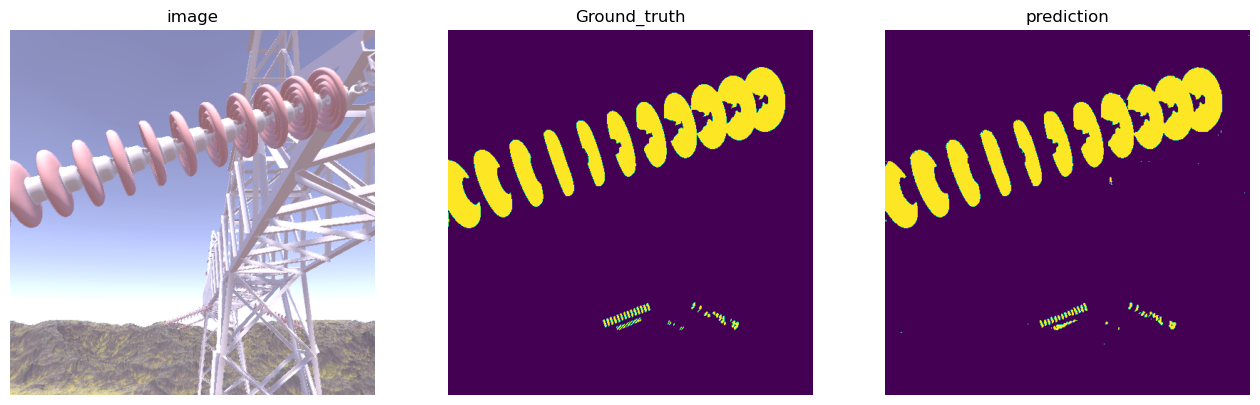

In [22]:
indx = np.random.randint(0, 2)
test_prediction = torch.argmax(y_hat[indx], 0).to('cpu').numpy()
Ground_truth = torch.argmax(y[indx], 0).to('cpu').numpy()
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(16,9))
ax1.imshow(x[indx].to('cpu').numpy().transpose(1,2,0))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(Ground_truth)
ax2.set_title('Ground_truth')
ax2.axis('off')
ax3.imshow(test_prediction)
ax3.set_title("prediction")
ax3.axis('off')


In [23]:

torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/linknet_vgg19_porcelain.pth')

In [24]:
#load model 
model_path =r'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/linknet_vgg19_porcelain.pth'
model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
model.load_state_dict(torch.load(model_path))

C:\Users\User\AppData\Local\Temp\ipykernel_11824\2672600750.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [25]:
model.to('cuda')

Linknet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
   

In [26]:
dir = 'C:/Users/User/Desktop/rakin2/segment/notebook/real_dataset.csv'

In [27]:
transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    # A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    # A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    # A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
], is_check_shapes=False)

In [28]:
real_data = SegmentDataset(dir,2,transform=transform )

In [29]:
real_dataloader = torch.utils.data.DataLoader(real_data, batch_size=10, shuffle=True)

In [30]:
#images, masks = next(iter(real_dataloader))

In [31]:
print(f'sahpe of the image {images.shape} and mask {masks.shape} ,images type {type(images)} and mask type {type(masks)}')

sahpe of the image torch.Size([2, 3, 512, 512]) and mask torch.Size([2, 2, 512, 512]) ,images type <class 'torch.Tensor'> and mask type <class 'torch.Tensor'>


In [32]:
#model.eval()
#real_predictions = []

#with torch.no_grad():
    #for images, masks in tqdm(real_dataloader):
        #images = images.to('cuda')
        #masks = masks.to('cuda')
        #outputs = model(images)
        #preds = torch.argmax(outputs, dim=1)
        #0+.
#real_predictions.append(preds.cpu().numpy())


In [33]:
plt.figure(figsize=(16, 16))

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

In [34]:
# import matplotlib.pyplot as plt
# random_indx = np.random.randint(0, 1000)
# Select a random index to visualize
# indx = np.random.randint(0, len(images))

# Get the image, ground truth, and prediction
# image = images[indx].to('cpu').numpy().transpose(1, 2, 0)
# ground_truth = torch.argmax(masks[indx], 0).to('cpu').numpy()
# prediction = torch.argmax(outputs[indx], 0).to('cpu').numpy()

# Plot the image, ground truth, and prediction
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
# ax1.imshow(image)
# ax1.set_title('Image')
# ax1.axis('off')
# ax2.imshow(prediction)
# ax2.set_title('Ground Truth')
# ax2.axis('off')
# plt.savefig(f'prediction{random_indx}.png')
# plt.show()